# Synthetic Control for Hungary

In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
bonds=pd.read_parquet('../data/processed/bonds.parq')
if bonds['bond_yield'].isna().all():
    rng=np.random.default_rng(0)
    bonds['bond_yield']=rng.normal(4,0.5,len(bonds))

In [3]:
pre=bonds[bonds.date<"2022-12-22"]
mat=pre.pivot(index="date",columns="country",values="bond_yield").fillna(0)
donors_df=mat.drop(columns="HU")
target=mat["HU"].to_numpy()
donors=donors_df.to_numpy()
W=cp.Variable(donors.shape[1])
objective=cp.Minimize(cp.sum_squares(target - donors@W))
constraints=[W>=0, cp.sum(W)==1]
cp.Problem(objective,constraints).solve()
weights=pd.Series(W.value, index=donors_df.columns)
full=bonds.pivot(index="date",columns="country",values="bond_yield").fillna(0)
synthetic=full[weights.index]@weights
full_hu=full["HU"]
gap=full_hu - synthetic

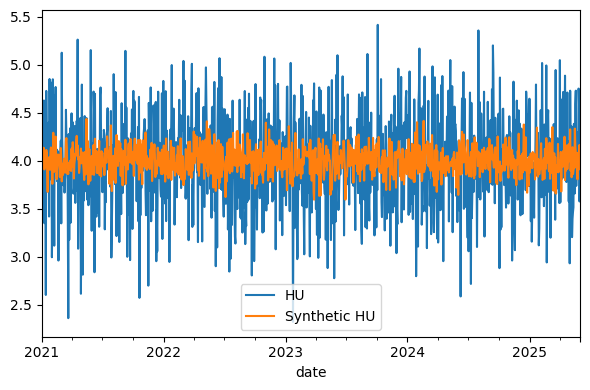

In [4]:
ax=full_hu.plot(label="HU",figsize=(6,4))
synthetic.plot(ax=ax,label="Synthetic HU")
plt.legend();plt.tight_layout();

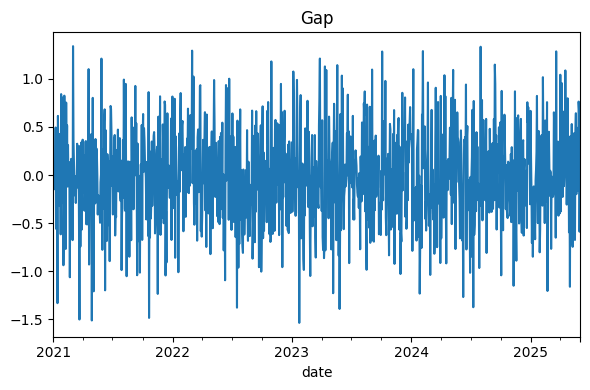

In [5]:
gap.plot(title="Gap",figsize=(6,4));plt.tight_layout();

In [6]:
weights.to_frame("weight")

,weight
country,
AT,1.192952e-03
BE,1.138295e-02
BG,5.933259e-15
CY,1.172189e-01
CZ,9.327554e-02
DE,1.180670e-01
DK,2.380950e-15
EE,2.460158e-03
ES,5.733213e-02


In [7]:
# placebo gaps
placebos=[]
for c in donors_df.columns:
    donors_loo=donors_df.drop(columns=c).to_numpy()
    Wp=cp.Variable(donors_loo.shape[1])
    cp.Problem(cp.Minimize(cp.sum_squares(target - donors_loo@Wp)),[Wp>=0,cp.sum(Wp)==1]).solve()
    synth=full[donors_df.drop(columns=c).columns]@Wp.value
    placebos.append((full[c]-synth).rename(c))
placebo_df=pd.concat(placebos,axis=1)

In [8]:
p_val=(placebo_df.abs().ge(gap.abs(),axis=0).sum(axis=1)+1)/(len(placebos)+1)
p_val.tail()

date
2025-05-26    0.714286
2025-05-27    0.107143
2025-05-28    0.392857
2025-05-29    0.250000
2025-05-30    0.678571
dtype: float64

In [9]:
gap.to_frame('gap').to_parquet('../data/processed/hu_gap.parq')